# Однофакторный анализ фичей

Входные данные data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи

Каждая фича более подробно рассматривалась feature_primary_analysis/analysis_features_part(*).ipynb

Нестабильные или не репрезентативные фичи будут исключены

In [20]:
import pandas as pd

In [21]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [22]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [23]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/feature_one_factor_analysis.xlsx"
writer = ExcelWriter(name)

In [24]:
#  timedelta с делаем в днях и числовыми значениями
target_features = days_substitute(target_features)
# target_features.head(2)

#### Теперь формируем выборки для фрод и кред дефолта

In [25]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению
target_cred = Target(type='кред', target_data=target_features)# это кред дефолт, макс по обращению

target_frod.print_param()
target_cred.print_param()

target_frod.data = target_frod.data
target_cred.data = target_cred.data


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4708 из 63131 (7.46%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1977 из 43723 (4.52%)


In [26]:
print(stable_features)

['no_contracts_total', 'no_transport_total', 'no_contracts_active', 'no_transp_active', 'no_contracts_closed', 'reason_гибель/тотал', 'reason_завершение', 'reason_замена/перенайм/переуступка', 'reason_не указана', 'reason_определена цессия', 'reason_отмена', 'reason_расторгнут', 'reason_страховой случай', 'reason_страховой случай (гибель/тотал)', 'bad_reasons_closed', 'good_reasons_closed', 'not_determined_reasons_closed', 'mean_bad_reasons', 'mean_good_reasons', 'mean_not_determined_reasons', 'no_creditors', 'duration_max', 'duration_mean', 'duration_min', 'end_date_first']


## Logregression 

### Дефолтные сделки (фрод метка)

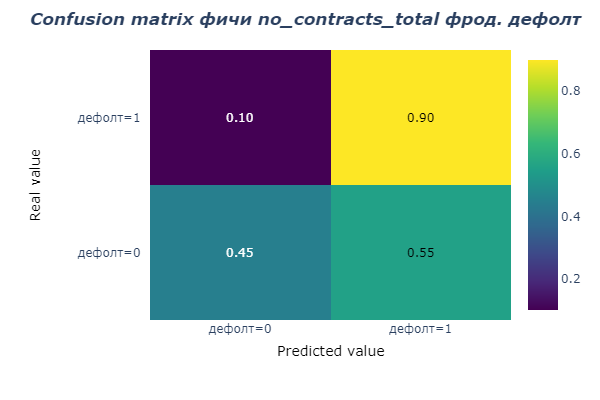

,feature,rocauc,accuracy,recall,intercept,coef
0,no_contracts_total,0.67,0.48,0.9,-0.4279,[-2.1668]


In [27]:
type = target_frod.type
df_metriсs_frod = pd.DataFrame()

list_of_figs = []

for feature in stable_features:

    X_raw = np.asarray(target_frod.data[[feature]])
    y = np.asarray(target_frod.data['Метка дефолта'])

    log = LogReg(X_raw, y)

    metrics = log.metrics()
    coefs = log.get_coef()

    rocauc = metrics.get('rocauc')
    accuracy = metrics.get('accuracy')
    recall = metrics.get('recall')

    intercept = coefs.get('intercept')
    coef = coefs.get('coef')

    fig = log.plot_confusion_matrix(normalize='true', show=False, 
                                    title = 'Confusion matrix фичи ' + feature + " фрод. дефолт")
    list_of_figs.append(fig)

    df_metriсs_frod = df_metriсs_frod.append(pd.DataFrame([{'feature':feature, 'rocauc':rocauc, 
                                    'accuracy':accuracy, 'recall':recall, 
                                    'intercept':intercept, 'coef':coef}]))

combine_plotly_figs_to_html(list_of_figs, pre+'data/html/confusion_matrixes_frod.html')
list_of_figs[0].show('png' if need_svg else '')

df_metriсs_frod = df_metriсs_frod.reset_index(drop=True)
df_metriсs_frod.to_excel(writer, sheet_name='df_metriсs_frod')                             
df_metriсs_frod.head(1)



In [28]:
print(df_metriсs_frod.sort_values(by='rocauc', ascending=False)['feature'][:4].to_list())
df_metriсs_frod.nlargest(5, 'rocauc', keep='all')

['no_contracts_total', 'no_contracts_closed', 'end_date_first', 'duration_mean']


,feature,rocauc,accuracy,recall,intercept,coef
0,no_contracts_total,0.67,0.48,0.90,-0.4279,[-2.1668]
4,no_contracts_closed,0.67,0.44,0.93,-0.6327,[-3.0602]
24,end_date_first,0.66,0.41,0.95,-0.5323,[-1.5361]
1,no_transport_total,0.65,0.43,0.92,-0.4290,[-2.2212]
21,duration_max,0.65,0.41,0.94,-0.4149,[-1.211]
22,duration_mean,0.65,0.41,0.94,-0.4003,[-1.1937]


In [29]:
print(df_metriсs_frod.sort_values(by='accuracy', ascending=False)['feature'][:3].to_list())
df_metriсs_frod.nlargest(5, 'accuracy', keep='all')

['no_contracts_total', 'no_contracts_closed', 'no_transport_total']


,feature,rocauc,accuracy,recall,intercept,coef
0,no_contracts_total,0.67,0.48,0.90,-0.4279,[-2.1668]
4,no_contracts_closed,0.67,0.44,0.93,-0.6327,[-3.0602]
1,no_transport_total,0.65,0.43,0.92,-0.4290,[-2.2212]
3,no_transp_active,0.64,0.43,0.89,-0.2531,[-1.5703]
21,duration_max,0.65,0.41,0.94,-0.4149,[-1.211]
22,duration_mean,0.65,0.41,0.94,-0.4003,[-1.1937]
24,end_date_first,0.66,0.41,0.95,-0.5323,[-1.5361]


In [30]:
print(df_metriсs_frod.sort_values(by='recall', ascending=False)['feature'][:3].to_list())
df_metriсs_frod.nlargest(1, 'recall', keep='all')

['reason_страховой случай', 'reason_гибель/тотал', 'reason_замена/перенайм/переуступка']


,feature,rocauc,accuracy,recall,intercept,coef
5,reason_гибель/тотал,0.50,0.07,1.0,-0.0003,[-0.0314]
7,reason_замена/перенайм/переуступка,0.50,0.07,1.0,-0.0013,[-0.1196]
9,reason_определена цессия,0.50,0.08,1.0,-0.0037,[-0.1868]
12,reason_страховой случай,0.51,0.08,1.0,-0.0358,[-0.5563]
13,reason_страховой случай (гибель/тотал),0.50,0.07,1.0,-0.0020,[-0.1352]


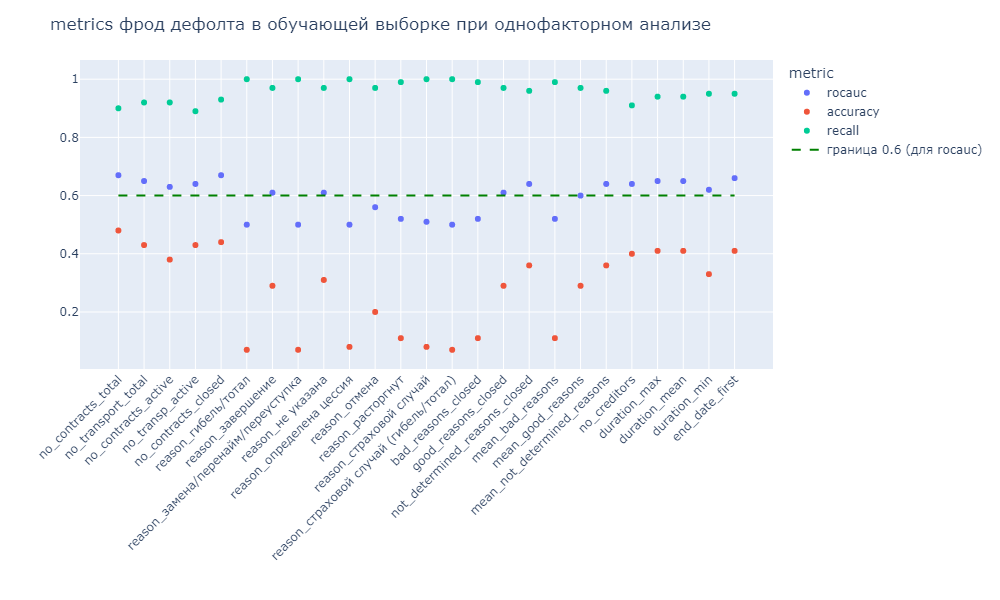

In [31]:
df = df_metriсs_frod[['feature',	'rocauc',	'accuracy',	'recall']]
long_format = df.melt(id_vars=['feature'], var_name="metric", value_name='value')

fig_frod = plot_metrics(long_format, title = 'metrics фрод дефолта в обучающей выборке при однофакторном анализе')

### Дефолтные сделки (кред метка)

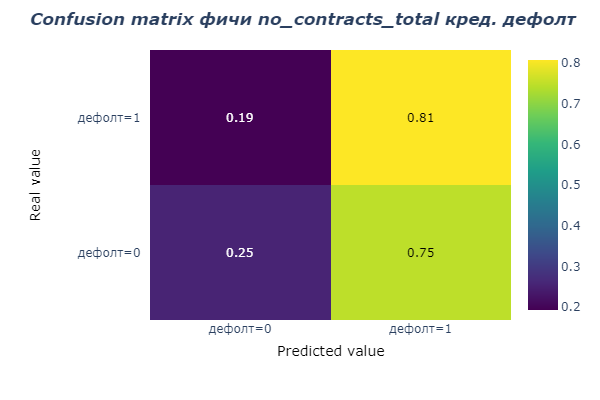

,feature,rocauc,accuracy,recall,intercept,coef
0,no_contracts_total,0.53,0.28,0.81,-0.0144,[-0.2153]


In [32]:
type = target_cred.type
df_metriсs_cred = pd.DataFrame()

list_of_figs = []
for feature in stable_features:

    X_raw = np.asarray(target_cred.data[[feature]])
    y = np.asarray(target_cred.data['Метка дефолта'])

    log = LogReg(X_raw, y)

    metrics = log.metrics()
    coefs = log.get_coef()

    rocauc = metrics.get('rocauc')
    accuracy = metrics.get('accuracy')
    recall = metrics.get('recall')

    intercept = coefs.get('intercept')
    coef = coefs.get('coef')

    fig = log.plot_confusion_matrix( normalize='true', show=False, 
                                    title = 'Confusion matrix фичи ' + feature+ " кред. дефолт")
    list_of_figs.append(fig)

    df_metriсs_cred = df_metriсs_cred.append(pd.DataFrame([{'feature':feature, 'rocauc':rocauc, 
                                    'accuracy':accuracy, 'recall':recall, 
                                    'intercept':intercept, 'coef':coef}]))

combine_plotly_figs_to_html(list_of_figs, pre+'data/html/confusion_matrixes_cred.html')
list_of_figs[0].show('png' if need_svg else '')

df_metriсs_cred = df_metriсs_cred.reset_index(drop=True)
df_metriсs_cred.to_excel(writer, sheet_name='df_metriсs_cred')                             
df_metriсs_cred.head(1)

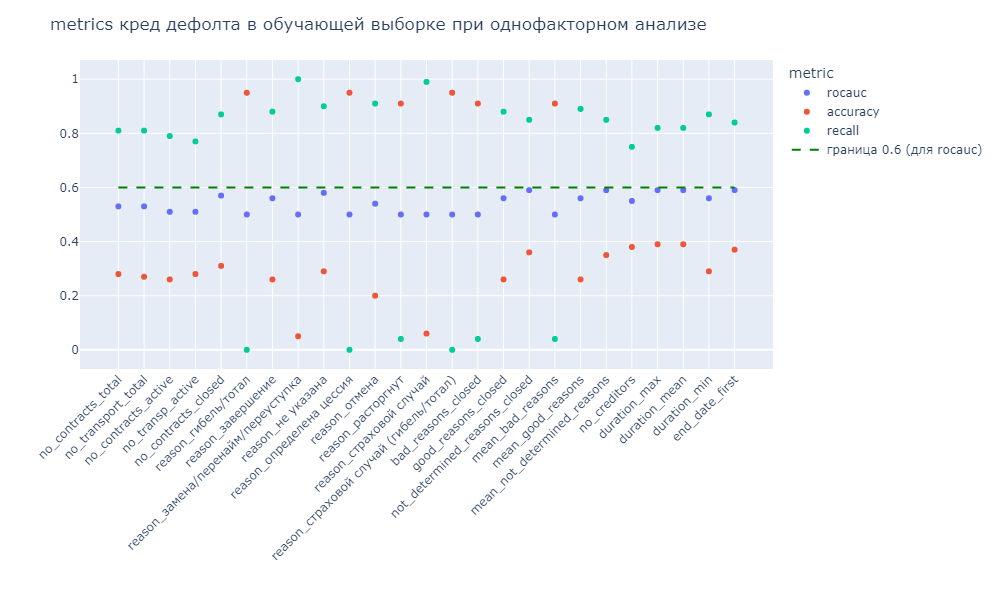

In [33]:
df = df_metriсs_cred[['feature',	'rocauc',	'accuracy',	'recall']]
long_format = df.melt(id_vars=['feature'], var_name="metric", value_name='value')

fig_cred = plot_metrics(long_format, title = 'metrics кред дефолта в обучающей выборке при однофакторном анализе' )


In [34]:
print(df_metriсs_cred.sort_values(by='rocauc', ascending=False)['feature'][:4].to_list())
df_metriсs_cred.nlargest(5, 'rocauc', keep='all')

['end_date_first', 'duration_mean', 'duration_max', 'mean_not_determined_reasons']


,feature,rocauc,accuracy,recall,intercept,coef
16,not_determined_reasons_closed,0.59,0.36,0.85,-0.0569,[-0.4954]
19,mean_not_determined_reasons,0.59,0.35,0.85,-0.0845,[-0.4622]
21,duration_max,0.59,0.39,0.82,-0.0566,[-0.3637]
22,duration_mean,0.59,0.39,0.82,-0.0579,[-0.3688]
24,end_date_first,0.59,0.37,0.84,-0.0609,[-0.3819]


In [35]:
print(df_metriсs_cred.sort_values(by='accuracy', ascending=False)['feature'][:6].to_list())
df_metriсs_cred.nlargest(5, 'accuracy', keep='all')

['reason_гибель/тотал', 'reason_определена цессия', 'reason_страховой случай (гибель/тотал)', 'reason_расторгнут', 'mean_bad_reasons', 'bad_reasons_closed']


,feature,rocauc,accuracy,recall,intercept,coef
5,reason_гибель/тотал,0.5,0.95,0.00,-0.0001,[0.0131]
9,reason_определена цессия,0.5,0.95,0.00,-0.0001,[0.0277]
13,reason_страховой случай (гибель/тотал),0.5,0.95,0.00,-0.0002,[0.0161]
11,reason_расторгнут,0.5,0.91,0.04,-0.0016,[0.0609]
14,bad_reasons_closed,0.5,0.91,0.04,-0.0017,[0.0622]
17,mean_bad_reasons,0.5,0.91,0.04,-0.0038,[0.0811]


In [36]:
print(df_metriсs_cred.sort_values(by='recall', ascending=False)['feature'][:3].to_list())
df_metriсs_cred.nlargest(5, 'recall', keep='all')

['reason_замена/перенайм/переуступка', 'reason_страховой случай', 'reason_отмена']


,feature,rocauc,accuracy,recall,intercept,coef
7,reason_замена/перенайм/переуступка,0.50,0.05,1.00,-0.0019,[-0.2101]
12,reason_страховой случай,0.50,0.06,0.99,-0.0032,[-0.1055]
10,reason_отмена,0.54,0.20,0.91,-0.0206,[-0.2974]
8,reason_не указана,0.58,0.29,0.90,-0.0545,[-0.494]
18,mean_good_reasons,0.56,0.26,0.89,-0.0316,[-0.279]


In [37]:
combine_plotly_figs_to_html([fig_frod, fig_cred], pre+'data/html/metrics_one_factor.html')

In [38]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()